In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics
import keras.backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

data = pd.read_csv("Data_MachineLearning/df_reduced.csv")
data.head()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17686071886566804613
]


,news,is_relevant,Armed Assault,Bombing/Explosion,Kidnapping,Other
0,Two Lashkar e Jhangvi LeJ militants Asim alias...,True,True,False,False,False
1,The Commander Southern Command Lieutenant Gene...,True,False,False,False,True
2,Meanwhile the underground organization Manipur...,True,False,True,False,False
3,Islamic State IS in the latest issue of its on...,True,True,False,False,False
4,A senior Muttahida Qaumi Movement MQM worker i...,True,False,False,False,True


<AxesSubplot:ylabel='Frequency'>

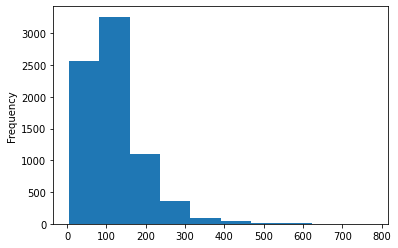

In [2]:
data.news.str.split().str.len().plot.hist()

In [3]:
def f1_multilabel(labels, predictions):
    
    f1 = 0.
    count = 0
    for lab, pred in zip(labels, predictions):
        lab_den = [i for i, l in enumerate(lab) if l == 1]
        pred_den = [i for i, p in enumerate(pred) if p == 1]
        den = len(lab_den) + len(pred_den)
        if den>0:
            count+=1
            num = 2*sum([1 if l==p==1 else 0 for l, p in zip(lab,pred)])
            f1+=(num/den)

    if count == 0:
        return 0.
    else:
        return f1/count




def accuracy_multilabel(labels, predictions):

    acc = 0.
    count = 0
    for lab, pred in zip(labels, predictions):

        lab_den = [i for i, l in enumerate(lab) if l == 1]
        pred_den = [i for i, p in enumerate(pred) if p == 1]
        den = len(set(lab_den + pred_den))

        if den>0:
            count+=1
            num = sum([1 if l==p==1 else 0 for l, p in zip(lab,pred)])
            acc+=(num/den)
            
    if count == 0:
        return 0.
    else:
        return acc/count



def precision_multilabel(labels, predictions):
    prec = 0.
    count = 0
    for lab, pred in zip(labels, predictions):
        pred_den = [i for i, p in enumerate(pred) if p == 1]
        den = len(pred_den)
        
        if den>0:
            count+=1 
            num = sum([1 if l==p==1 else 0 for l, p in zip(lab,pred)])
            prec+=(num/den)
            
    if count == 0:
        return 0.
    else:
        return  prec/count


def recall_multilabel(labels, predictions):
    rec = 0.
    count = 0
    for lab, pred in zip(labels, predictions):
        lab_den = [i for i, l in enumerate(lab) if l == 1]
        den = len(lab_den)
        
        if den>0:
            count+=1
            num = sum([1 if l==p==1 else 0 for l, p in zip(lab,pred)])
            rec+=(num/den)
    if count == 0:
        return 0.
    else:
        return  rec/count

In [4]:
def cleanHtml(sentence):  # remove html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence): # clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):  # Remove non-alphabetic characters
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

data['news'] = data['news'].str.lower()
data['news'] = data['news'].apply(cleanHtml)
data['news'] = data['news'].apply(cleanPunc)
data['news'] = data['news'].apply(keepAlpha)

In [5]:
df_train = data.sample(frac=0.8,random_state=200) #random state is a seed value
df_test = data.drop(df_train.index)

print(df_train.shape)
print(df_test.shape)

(5954, 6)
(1489, 6)


In [6]:
x_train = df_train['news'].values
y_train = df_train.iloc[:,1:].values

x_test = df_test['news'].values
y_test = df_test.iloc[:,1:].values

In [7]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(x_train))

train_seq = tokenizer.texts_to_sequences(x_train)
train_pad = sequence.pad_sequences(train_seq, maxlen=300)

test_seq = tokenizer.texts_to_sequences(x_test)
test_pad = sequence.pad_sequences(test_seq, maxlen=300)

In [8]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



### Defining the custom metric function F1
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


from tensorflow.keras.callbacks import Callback

### Defining the Callback Metrics
class Metrics(Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = round(f1_score(val_targ, val_predict), 6)
        val_recall = round(recall_score(val_targ, val_predict), 6)     
        val_precision = round(precision_score(val_targ, val_predict), 6)
        
        self.val_f1s.append(val_f1)
        self.val_recalls.append(val_recall)
        self.val_precisions.append(val_precision)
 
        print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')



In [9]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,hamming_loss
#                          recall_score(df_target[col], df_pred[col], average='macro'),
#                         precision_score(df_target[col], df_pred[col], average='macro'),
#                         f1_score(df_target[col], df_pred[col], average='macro')

def ac(y_true, y_pred): 
    y_true, y_pred = tf.make_tensor_proto(y_true),  tf.make_tensor_proto(y_pred)
    y_true, y_pred = tf.make_ndarray(y_true),  tf.make_ndarray(y_pred)
#     y_true, y_pred = y_true.numpy(), y_pred.numpy()
    return accuracy_score(y_true, y_pred)
def rec (y_true, y_pred): 
    return recall_score(y_true, y_pred, average='macro')
def re (y_true, y_pred): 
    return precision_score(y_true, y_pred, average='macro'),
def f1 (y_true, y_pred): 
    return f1_score(y_true, y_pred, average='macro')

import tensorflow_addons as tfa

In [10]:

inputs = Input(shape=(300, ))
x = Embedding(20000, 256)(inputs)
x = Bidirectional(LSTM(100))(x)
x = Dropout(0.1)(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(5, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
#               metrics=['accuracy',
#                        'binary_accuracy',
# #                       "top_k_categorical_accuracy", 
#                        metrics.AUC(),
#                        f1_score]
              metrics = ['acc',
#                          precision_m, recall_m, f1_m,
#                          metrics.Precision(),
#                          metrics.Recall(),
                         tfa.metrics.F1Score(num_classes=5, average='macro')
#                          ac, 
#                          rec, pre,f1
 
                        
                        ])


# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics = [])


model.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 256)          5120000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               285600    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505   

In [11]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=20)
# my_metric = Metrics()
model.fit(train_pad, y_train, 
          batch_size=1024,
          
          epochs=200, 
          validation_split=0.1, 
#           callbacks=[]
          callbacks=early_stop
#           callbacks=[early_stop, my_metric]
         )
          

Epoch 1/200
6/6 [==============================] - 11s 2s/step - loss: 0.6739 - acc: 0.4534 - f1_score: 0.1135 - val_loss: 0.5446 - val_acc: 1.0000 - val_f1_score: 0.0656
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 0.4672 - acc: 0.9558 - f1_score: 0.0791 - val_loss: 0.2882 - val_acc: 1.0000 - val_f1_score: 0.0656
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 0.3121 - acc: 0.9478 - f1_score: 0.0837 - val_loss: 0.2693 - val_acc: 1.0000 - val_f1_score: 0.0656
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 0.2854 - acc: 0.9258 - f1_score: 0.0832 - val_loss: 0.2677 - val_acc: 1.0000 - val_f1_score: 0.0656
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 0.2916 - acc: 0.9166 - f1_score: 0.0897 - val_loss: 0.2645 - val_acc: 1.0000 - val_f1_score: 0.0656
Epoch 6/200
6/6 [==============================] - 7s 1s/step - loss: 0.2804 - acc: 0.9649 - f1_score: 0.0791 - val_loss: 0.2634 - val_acc: 1.0000 - 

In [12]:
outputs = model.predict([test_pad], batch_size=1024, verbose=1)
# model.evaluate(test_pad, outputs, batch_size=32, verbose=2)

2/2 [==============================] - 1s 536ms/step


In [13]:
# import pickle
# with open('bilstm_output.pt','wb') as file:
#     pickle.dump(outputs, file)

In [15]:
outputs

array([[2.8409304e-05, 3.5519930e-05, 2.3704039e-05, 9.4633087e-06,
        4.8667316e-05],
       [6.3919229e-05, 7.7372228e-05, 4.1510772e-05, 1.9276651e-05,
        1.0046235e-04],
       [9.2872918e-01, 7.4782056e-01, 7.3134303e-03, 6.5694720e-02,
        1.5378863e-01],
       ...,
       [1.7347837e-05, 2.3062770e-05, 1.6391099e-05, 6.4238316e-06,
        3.1488456e-05],
       [9.9776745e-01, 6.4662367e-02, 9.8081553e-01, 1.1590719e-02,
        3.1181842e-02],
       [6.4316504e-05, 7.5728021e-05, 4.2713316e-05, 1.9066358e-05,
        9.9659155e-05]], dtype=float32)

In [28]:
pred = outputs >= 0.5

In [43]:
pred[pred[:,0]==True]


array([[ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True, False, False, False],
       ...,
       [ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [ True, False,  True, False, False]])

In [42]:
# pred[pred[:,0]== False]=0
i=0
for row in pred:
    
    if row[0]== True and ~row[1:].any():
        print(row)
        i +=1
print(i)

[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True False False False False]
[ True F

In [17]:
df = pd.DataFrame(columns = ['threshold','type','accuracy', 
                             'recall(micro)', 'precision(micro)', 'f1(micro)', 
                             'recall(macro)', 'precision(macro)', 'f1(macro)', 
                             'hamming',

                            'accuracy(custom)', 'EMR',
                             'recall(custom)', 'precision(custom)', 'f1(custom)',
                            ])
targets = y_test

Threshold = np.around(np.linspace(0.1, 0.9, 9),1)

for threshold in Threshold:
    print('threshold', threshold)
    pred = outputs >= threshold
    
    
    # ToDo  加了就等于屏蔽relevant
    pred[:,]

#     accuracy = accuracy_score(targets, outputs)
#     f1_score_micro = f1_score(targets, outputs, average='micro')
#     f1_score_macro = f1_score(targets, outputs, average='macro')
#     print(f"Accuracy Score = {accuracy}")
#     print(f"F1 Score (Micro) = {f1_score_micro}")
#     print(f"F1 Score (Macro) = {f1_score_macro}")


    df.loc[len(df)] = [threshold, 
                       'all', 
                       accuracy_score(targets, pred),
                       recall_score(targets, pred, average='micro'),
                       precision_score(targets, pred, average='micro'),
                       f1_score(targets, pred, average='micro'),
                       recall_score(targets, pred, average='macro'),
                       precision_score(targets, pred, average='macro'),
                       f1_score(targets, pred, average='macro'),
                       hamming_loss(targets, pred),
                       
                        accuracy_multilabel(targets, pred),                         
                        accuracy_score(np.array(targets), np.array(pred)),
                        recall_multilabel(targets, pred),
                        precision_multilabel(targets, pred),
                        f1_multilabel(targets, pred)  
                       ]
    
    
    df.loc[len(df)] = [threshold, 
                       'multi', 
                       accuracy_score(targets[:,1:], pred[:,1:]),
                       recall_score(targets[:,1:], pred[:,1:], average='micro'),
                       precision_score(targets[:,1:], pred[:,1:], average='micro'),
                       f1_score(targets[:,1:], pred[:,1:], average='micro'),
                       recall_score(targets[:,1:], pred[:,1:], average='macro'),
                       precision_score(targets[:,1:], pred[:,1:], average='macro'),
                       f1_score(targets[:,1:], pred[:,1:], average='macro'),
                       hamming_loss(targets, pred),
                       
                        accuracy_multilabel(targets[:,1:], pred[:,1:]),                         
                        accuracy_score(np.array(targets[:,1:]), np.array(pred[:,1:])),
                        recall_multilabel(targets[:,1:], pred[:,1:]),
                        precision_multilabel(targets[:,1:], pred[:,1:]),
                        f1_multilabel(targets[:,1:], pred[:,1:])  
                       ]
    
    
    
    df_target = pd.DataFrame(targets)
    df_target.columns = ['is_relevant',	'Armed Assault',	'Bombing/Explosion',	'Kidnapping',	'Other']

    df_pred = pd.DataFrame(pred)
    df_pred.columns = df_target.columns
    
    for col in df_pred.columns:

        df.loc[len(df)] = [threshold, 
                           col, 
                           accuracy_score(df_target[col], df_pred[col]),
                           recall_score(df_target[col], df_pred[col], average='micro'),
                           precision_score(df_target[col], df_pred[col], average='micro'),
                           f1_score(df_target[col], df_pred[col], average='micro'),
                           recall_score(df_target[col], df_pred[col], average='macro'),
                           precision_score(df_target[col], df_pred[col], average='macro'),
                           f1_score(df_target[col], df_pred[col], average='macro'),
                           hamming_loss(df_target[col], df_pred[col]),
                           
                            None, None, None, None, None
                           
                           ]

df

threshold 0.1
threshold 0.2
threshold 0.3
threshold 0.4
threshold 0.5
threshold 0.6


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold 0.7
threshold 0.8
threshold 0.9


,threshold,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),hamming,accuracy(custom),EMR,recall(custom),precision(custom),f1(custom)
0,0.1,all,0.738079,0.690828,0.456947,0.550059,0.573441,0.396224,0.452517,0.102619,0.358935,0.738079,0.688088,0.466406,0.41688
1,0.1,multi,0.752183,0.621849,0.347418,0.445783,0.524795,0.335358,0.391145,0.102619,0.29396,0.752183,0.620167,0.3841,0.346254
2,0.1,is_relevant,0.857623,0.857623,0.857623,0.857623,0.825038,0.786389,0.802430,0.142377,None,None,None,None,None
3,0.1,Armed Assault,0.856279,0.856279,0.856279,0.856279,0.804889,0.662221,0.697358,0.143721,None,None,None,None,None
4,0.1,Bombing/Explosion,0.946273,0.946273,0.946273,0.946273,0.791611,0.817076,0.803679,0.053727,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.9,is_relevant,0.879113,0.879113,0.879113,0.879113,0.790831,0.832687,0.808791,0.120887,None,None,None,None,None
59,0.9,Armed Assault,0.913365,0.913365,0.913365,0.913365,0.518202,0.814295,0.513252,0.086635,None,None,None,None,None
60,0.9,Bombing/Explosion,0.942915,0.942915,0.942915,0.942915,0.690194,0.850507,0.741981,0.057085,None,None,None,None,None
61,0.9,Kidnapping,0.983882,0.983882,0.983882,0.983882,0.500000,0.491941,0.495938,0.016118,None,None,None,None,None


In [34]:
df[df.type == 'all']

,threshold,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),hamming,accuracy(custom),EMR,recall(custom),precision(custom),f1(custom)
0,0.1,all,0.689053,0.726331,0.365872,0.486620,0.593398,0.330761,0.403296,0.139154,0.303165,0.689053,0.726228,0.368779,0.370996
7,0.2,all,0.711216,0.665680,0.430622,0.522952,0.508875,0.352145,0.397539,0.110275,0.333926,0.711216,0.667189,0.432724,0.39477
14,0.3,all,0.732707,0.634615,0.479866,0.546497,0.471955,0.374058,0.401989,0.095635,0.35273,0.732707,0.636364,0.482234,0.410704
21,0.4,all,0.762257,0.582840,0.554149,0.568133,0.398510,0.423946,0.383901,0.080457,0.371162,0.762257,0.585162,0.538194,0.421272
28,0.5,all,0.767629,0.542899,0.577953,0.559878,0.352085,0.349732,0.337503,0.077502,0.365141,0.767629,0.546499,0.562162,0.41503
35,0.6,all,0.760242,0.500000,0.590909,0.541667,0.311459,0.350364,0.316030,0.076830,0.3454,0.760242,0.50418,0.586592,0.400603
42,0.7,all,0.760242,0.463018,0.636179,0.535959,0.280014,0.381171,0.308980,0.072801,0.337587,0.760242,0.46813,0.635693,0.395901
49,0.8,all,0.740094,0.392012,0.674300,0.495790,0.208167,0.374025,0.242554,0.072398,0.297084,0.740094,0.397074,0.674772,0.371316
56,0.9,all,0.742109,0.347633,0.712121,0.467197,0.176252,0.298316,0.205985,0.071995,0.275184,0.742109,0.35162,0.70202,0.351188


In [44]:
df[df.type == 'multi']

,threshold,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),hamming,accuracy(custom),EMR,recall(custom),precision(custom),f1(custom)
1,0.1,multi,0.752183,0.621849,0.347418,0.445783,0.524795,0.335358,0.391145,0.102619,0.29396,0.752183,0.620167,0.3841,0.346254
8,0.2,multi,0.791135,0.532213,0.439815,0.481622,0.418814,0.381301,0.385974,0.082337,0.336158,0.791135,0.530825,0.469745,0.367554
15,0.3,multi,0.813298,0.476190,0.512048,0.493469,0.357390,0.393775,0.358250,0.074144,0.35589,0.813298,0.480669,0.527105,0.374269
22,0.4,multi,0.822028,0.445378,0.555944,0.494557,0.330931,0.434373,0.348468,0.070383,0.356529,0.822028,0.452456,0.561869,0.370275
29,0.5,multi,0.826729,0.394958,0.607759,0.478778,0.288909,0.475694,0.318123,0.067965,0.340889,0.826729,0.402299,0.604803,0.350667
36,0.6,multi,0.826058,0.364146,0.640394,0.464286,0.265210,0.518629,0.303385,0.066085,0.322917,0.826058,0.372518,0.638614,0.331975
43,0.7,multi,0.826058,0.322129,0.688623,0.438931,0.233935,0.473790,0.283400,0.064338,0.296714,0.826058,0.330199,0.688623,0.305634
50,0.8,multi,0.820013,0.260504,0.704545,0.380368,0.190135,0.354536,0.247057,0.065547,0.247358,0.820013,0.26907,0.704545,0.254083
57,0.9,multi,0.807925,0.140056,0.746269,0.235849,0.107296,0.366071,0.146557,0.067696,0.144076,0.807925,0.149948,0.746269,0.146084


In [18]:
df[df.type == 'is_relevant']

,threshold,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),hamming,accuracy(custom),EMR,recall(custom),precision(custom),f1(custom)
2,0.1,is_relevant,0.857623,0.857623,0.857623,0.857623,0.825038,0.786389,0.802430,0.142377,None,None,None,None,None
9,0.2,is_relevant,0.862995,0.862995,0.862995,0.862995,0.820477,0.793736,0.805614,0.137005,None,None,None,None,None
16,0.3,is_relevant,0.863667,0.863667,0.863667,0.863667,0.814064,0.795209,0.803906,0.136333,None,None,None,None,None
23,0.4,is_relevant,0.866353,0.866353,0.866353,0.866353,0.813493,0.799506,0.806107,0.133647,None,None,None,None,None
30,0.5,is_relevant,0.866353,0.866353,0.866353,0.866353,0.807793,0.800357,0.803965,0.133647,None,None,None,None,None
37,0.6,is_relevant,0.871054,0.871054,0.871054,0.871054,0.807364,0.808775,0.808066,0.128946,None,None,None,None,None
44,0.7,is_relevant,0.875756,0.875756,0.875756,0.875756,0.804655,0.818773,0.811354,0.124244,None,None,None,None,None
51,0.8,is_relevant,0.875756,0.875756,0.875756,0.875756,0.798955,0.820897,0.809066,0.124244,None,None,None,None,None
58,0.9,is_relevant,0.879113,0.879113,0.879113,0.879113,0.790831,0.832687,0.808791,0.120887,None,None,None,None,None


In [ ]:
df[df.type == 'all']

In [ ]:
import numpy as np
from torch import Tensor
from sklearn.metrics import roc_curve, auc, hamming_loss, accuracy_score
import pdb

CLASSIFICATION_THRESHOLD: float = 0.5  # Best keep it in [0.0, 1.0] range

# def accuracy(out, labels):
#     outputs = np.argmax(out, axis=1)
#     return np.sum(outputs == labels)



def fbeta(y_pred, y_true,
#     y_pred: Tensor,
#     y_true: Tensor,
    beta: float = 1,
    eps: float = 1e-9,
):
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
#     if sigmoid:
#         y_pred = y_pred.sigmoid()
#     y_pred = (y_pred > thresh)
#     .float()
#     y_true = y_true
#     .float()
#     TP = (y_pred * y_true).sum(dim=1)
#     prec = TP / (y_pred.sum(dim=1) + eps)
#     rec = TP / (y_true.sum(dim=1) + eps)
    
    TP = (y_pred * y_true).sum(axis=1)
    prec = TP / (y_pred.sum(axis=1) + eps)
    rec = TP / (y_true.sum(axis=1) + eps)
    
    res = (prec * rec) / (prec * beta2 + rec + eps) * (1 + beta2)
    return res.mean().item()


def roc_auc(y_pred: Tensor, y_true: Tensor):
    # ROC-AUC calcualation
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return roc_auc["micro"]


def Hamming_loss(y_pred, y_true,
#     y_pred: Tensor,
#     y_true: Tensor,
#     sigmoid: bool = True,
#     thresh: float = CLASSIFICATION_THRESHOLD,
    sample_weight=None,
):
#     if sigmoid:
#         y_pred = y_pred.sigmoid()
#     y_pred = (y_pred > thresh)
#     .float()
    return hamming_loss(y_true, y_pred, sample_weight=sample_weight)


def Exact_Match_Ratio(y_pred, y_true,
#     y_pred: Tensor,
#     y_true: Tensor,
#     sigmoid: bool = True,
#     thresh: float = CLASSIFICATION_THRESHOLD,
    normalize: bool = True,
    sample_weight=None,
):
#     if sigmoid:
#         y_pred = y_pred.sigmoid()
#     y_pred = (y_pred > thresh)
#     .float()
    return accuracy_score(
        y_true, y_pred, normalize=normalize, sample_weight=sample_weight
    )


def F1(
#     y_pred: Tensor, y_true: Tensor, 
       y_pred, y_true,
       threshold: float = CLASSIFICATION_THRESHOLD):
    return fbeta(y_pred, y_true, thresh=threshold, beta=1)

In [ ]:
df

In [ ]:
# EXACT MATCH RATIO
print("EMR: ", accuracy_score(np.array(targets), np.array(pred)))
#ACCURACY
print("Accuracy: ", accuracy_multilabel(targets, pred))
#PRECISION
print("Precision: ", precision_multilabel(targets, pred))
#RECALL
print("Recall: ", recall_multilabel(targets, pred))
#F1-SCORE
print("F1-score: ", f1_multilabel(targets, pred))
[recall_score(targets, pred, average='weighted'),
 precision_score(targets, pred, average='weighted'),
 f1_score(targets, pred, average='micro'),
f1_score(targets, pred, average='macro'),
f1_score(targets, pred, average = 'weighted')]

# print("accuracy_score:", accuracy_score(targets, pred))
# print("Hamming_loss:", hamming_loss(targets, pred))

In [ ]:
recall_score(targets, pred, average='micro'),
# precision_score(targets, pred, average='micro')

In [ ]:
targets

In [ ]:
targets1.astype(int)

In [ ]:
recall_multilabel(targets1, pred1)

In [ ]:
recall_multilabel(targets.astype(int), pred.astype(int))

In [ ]:
recall_score(targets1, pred1, average='weighted'),
# precision_score(targets1, pred1, average='micro')

In [ ]:
y_pred = pred; y_true = targets;eps = 1e-9; beta=1

TP = (y_pred * y_true).sum(axis=1)
prec = TP / (y_pred.sum(axis=1) + eps)
rec = TP / (y_true.sum(axis=1) + eps)
res = (prec * rec) / (prec * beta + rec + eps) * (1 + beta)


In [ ]:
TP.mean(), prec.mean(), rec.mean(), res.mean()


In [ ]:
pred